In [1]:
import pandas as pd
import random 
import json

from functions import join_stocks_crypto, generate_rand_portfolios
from functions_post_clustering import simulate_evaluate_portfolio_subset, reoptimize_weights, kruskal_anova_test, dunn_bonferroni, run_simulation

c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
#GET THE DATA IN
df_all_stocks = pd.read_csv('stocks_data_filled.csv',index_col='Date')
cryptos_df = pd.read_csv('cryptos_data_new.csv', index_col='timestamp')

joined_df = join_stocks_crypto(cryptos_df, df_all_stocks, mode = 'stocks_left') #mode - either do left with crypto and fill NA for stocks or do left on stocks and leave out some dates for cryptos
joined_df.index = pd.to_datetime(joined_df.index)

returns_all = joined_df.pct_change()


tickers = list(df_all_stocks.columns)

random.seed(42)
random_portfolios = generate_rand_portfolios(n_reps=1000, n_stocks=15, tickers=tickers)


#Reassemble the portfolio jsons for minvar
min_var_portfolios = dict()
for i in range(1,1000):
    with open(f'min_variance_portfolio_jsons/my_dict{i}.json') as f:
        port = json.load(f)
        min_var_portfolios.update(port)

# with open(f"full_optimized_min_variance.json", "w") as f:
#     json.dump(min_var_portfolios, f, indent=4)

rand_ports_normal = random_portfolios.copy()
rand_ports_maxsharpe = reoptimize_weights(joined_df, random_portfolios, how='max_sharpe', min_weight=0.01)
rand_ports_equal_weights = reoptimize_weights(joined_df, random_portfolios, how='equal_weights', min_weight=0.01)

minvar_port_normal = min_var_portfolios.copy()
minvar_ports_maxsharpe = reoptimize_weights(joined_df, min_var_portfolios, how='max_sharpe', min_weight=0.01)
minvar_ports_equal_weights = reoptimize_weights(joined_df, min_var_portfolios, how='equal_weights', min_weight=0.01)


with open('all_optimized_sets_for_simulation.json') as f:
    crypto_supplemented_sets = json.load(f)


portfolio_sets = {'rand_ports_normal': rand_ports_normal,
                  'rand_ports_maxsharpe': rand_ports_maxsharpe, 
                  'rand_ports_equal_weights': rand_ports_equal_weights,
                  'minvar_port_normal': minvar_port_normal,  
                  'minvar_ports_maxsharpe': minvar_ports_maxsharpe, 
                  'minvar_ports_equal_weights': minvar_ports_equal_weights}

all_sets = portfolio_sets | crypto_supplemented_sets

In [3]:
portfolio_no_crypto_to_test = portfolio_sets['minvar_port_normal']['portfolio_1']
portfolio_with_crypto_to_test = crypto_supplemented_sets['minvar_w_cryptos_ahc_equalw']['portfolio_1']

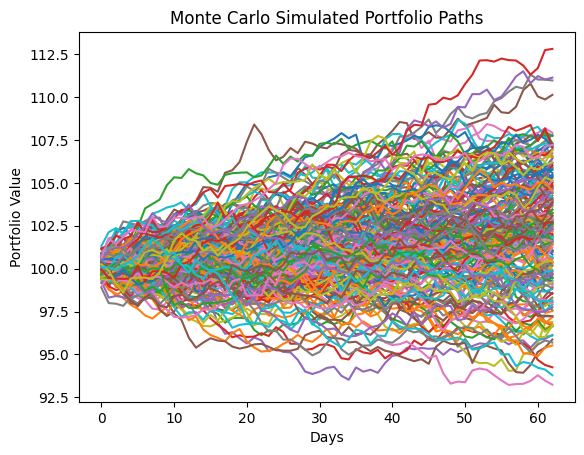

In [4]:
portfolio_sims_nocrypto = run_simulation(portfolio_no_crypto_to_test, returns_all, n_sims=200, t=63, distribution_model='multivar_norm', plot=True, initialPortfolio=100)

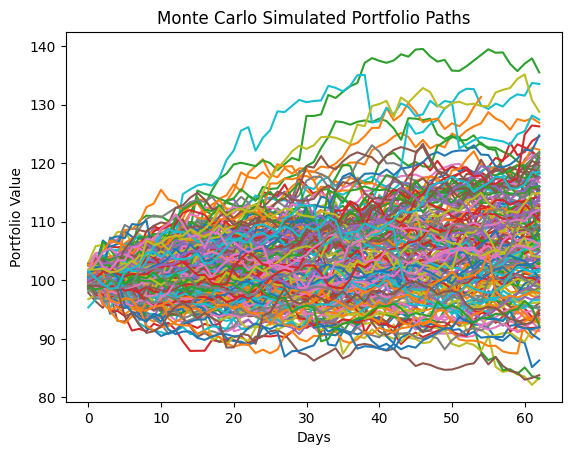

In [5]:
portfolio_sims_withcrypto = run_simulation(portfolio_with_crypto_to_test, returns_all, n_sims=200, t=63, distribution_model='bootstrap', plot=True, initialPortfolio=100)

SIMULATE AND EVALUATE

In [6]:
subset_statistics_results_dfs = dict()
normality_results_dfs = dict()

for key, portfolio_set in all_sets.items():
    for time_period in [63]:#, 126, 189, 252]:
        print(f'simulating {key}')
        simulations_results_dict, subset_statistics_df, normality = simulate_evaluate_portfolio_subset(portfolio_set, returns_all, n_sims=500, t=time_period, distribution_model='multivar_norm')
        subset_statistics_results_dfs[f'{key}_period{time_period}'] = subset_statistics_df
        normality_results_dfs[f'{key}_period{time_period}'] = normality

simulating rand_ports_normal
simulating rand_ports_maxsharpe
simulating rand_ports_equal_weights
simulating minvar_port_normal
simulating minvar_ports_maxsharpe
simulating minvar_ports_equal_weights
simulating random_w_cryptos_kmeans_equalw
simulating random_w_cryptos_kmeans_maxsharpe
simulating random_w_cryptos_kshape_equalw
simulating random_w_cryptos_kshape_maxsharpe
simulating random_w_cryptos_ahc_equalw
simulating random_w_cryptos_ahc_maxsharpe
simulating random_w_cryptos_random_equalw
simulating random_w_cryptos_random_maxsharpe
simulating minvar_w_cryptos_kmeans_equalw
simulating minvar_w_cryptos_kmeans_maxsharpe
simulating minvar_w_cryptos_kshape_equalw
simulating minvar_w_cryptos_kshape_maxsharpe
simulating minvar_w_cryptos_ahc_equalw
simulating minvar_w_cryptos_ahc_maxsharpe
simulating minvar_w_cryptos_random_equalw
simulating minvar_w_cryptos_random_maxsharpe


In [7]:
subset_statistics_results_dfs['minvar_port_normal_period63'].mean()

mean_cumulative_return    0.040199
mean_daily_return         0.000632
std_cumulative_return     0.046464
std_daily_return          0.005596
sharpe_daily              0.080352
sharpe_cumulative         0.627249
sharpe_annual             1.275556
VaR                       0.857251
CVaR                      1.090877
sortino                   0.121843
sortino_annual            1.934194
diversification_ratio          NaN
dtype: float64

In [8]:
kruskal_anova_test(subset_statistics_results_dfs, metrics='all', test='kruskal')

,test_stat,test_p
mean_cumulative_return,4321.0321,0.0
mean_daily_return,4320.3958,0.0
std_cumulative_return,7404.0948,0.0
std_daily_return,7832.2638,0.0
sharpe_daily,13461.3057,0.0
sharpe_cumulative,13865.4236,0.0
sharpe_annual,13461.3057,0.0
VaR,8178.8953,0.0
CVaR,8107.6651,0.0
sortino,13460.4792,0.0


In [9]:
x = dunn_bonferroni(subset_statistics_results_dfs, metrics='all')
x['mean_cumulative_return']

c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\scikit_posthocs\_posthocs.py:365: RuntimeWarning: divide by zero encountered in divide
  B = 1.0 / x_lens.loc[i] + 1.0 / x_lens.loc[j]


,minvar_port_normal_period63,minvar_ports_equal_weights_period63,minvar_ports_maxsharpe_period63,minvar_w_cryptos_ahc_equalw_period63,minvar_w_cryptos_ahc_maxsharpe_period63,minvar_w_cryptos_kmeans_equalw_period63,minvar_w_cryptos_kmeans_maxsharpe_period63,minvar_w_cryptos_kshape_equalw_period63,minvar_w_cryptos_kshape_maxsharpe_period63,minvar_w_cryptos_random_equalw_period63,...,rand_ports_maxsharpe_period63,rand_ports_normal_period63,random_w_cryptos_ahc_equalw_period63,random_w_cryptos_ahc_maxsharpe_period63,random_w_cryptos_kmeans_equalw_period63,random_w_cryptos_kmeans_maxsharpe_period63,random_w_cryptos_kshape_equalw_period63,random_w_cryptos_kshape_maxsharpe_period63,random_w_cryptos_random_equalw_period63,random_w_cryptos_random_maxsharpe_period63
minvar_port_normal_period63,1.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.000,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0000
minvar_ports_equal_weights_period63,0.0,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0005,...,0.0077,0.001,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0000
minvar_ports_maxsharpe_period63,0.0,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,...,0.0000,1.000,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0107,0.0000
minvar_w_cryptos_ahc_equalw_period63,0.0,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,...,0.0000,0.000,0.2691,0.0,0.0420,0.0,0.0004,0.0,0.0000,0.0282
minvar_w_cryptos_ahc_maxsharpe_period63,0.0,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,...,0.0000,0.000,0.8909,0.0,0.1641,0.0,0.0021,0.0,0.0000,0.1141
minvar_w_cryptos_kmeans_equalw_period63,0.0,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,...,0.0000,0.000,0.4750,0.0,0.0800,0.0,0.0009,0.0,0.0000,0.0546
minvar_w_cryptos_kmeans_maxsharpe_period63,0.0,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,...,0.0000,0.000,0.7711,0.0,0.1391,0.0,0.0017,0.0,0.0000,0.0963
minvar_w_cryptos_kshape_equalw_period63,0.0,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,...,0.0000,0.000,1.0000,0.0,0.3307,0.0,0.0052,0.0,0.0000,0.2341
minvar_w_cryptos_kshape_maxsharpe_period63,0.0,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,...,0.0000,0.000,1.0000,0.0,0.2922,0.0,0.0045,0.0,0.0000,0.2061
minvar_w_cryptos_random_equalw_period63,0.0,0.0005,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,...,0.0000,1.000,0.0000,0.0,0.0000,0.0,0.0000,0.0,1.0000,0.0000
